In [1]:
import joblib
from gensim.corpora import Dictionary
import gensim.corpora as corpora
from gensim.corpora import MmCorpus
from gensim import corpora, models, matutils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans, Birch, DBSCAN

import pandas as pd
import matplotlib.colors as mcolors


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from sklearn.cluster import AffinityPropagation

from time import time


from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer

from yellowbrick.cluster import SilhouetteVisualizer


from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

# Import LDA model

In [3]:
corpus = MmCorpus("corpus.corp")
texts = joblib.load('texts.pkl')
fulltexts = joblib.load('fulltexts.pkl')
model_list_6 = joblib.load('model_list_6.pkl')
lda_model = model_list_6[6]
dictionary = Dictionary.load("dictionary.dict")

# Deviation function

In [2]:
def deviation(num_clusters, kmeans_labels, cluster_vectors, X):
    print("Cluster number: {}".format(num_clusters))
    tweet_labels = [0 for x in range(0,num_clusters)] #inicializamos labels
    for label in kmeans_labels: #para cada tweet, guarda la label del cluster
        tweet_labels[label] = tweet_labels[label] + 1
    tweet_labels 
    
    # Creamos voy asignando una label al final de cada vector
    for i, vector in enumerate(X): 
        np.append(vector, kmeans_labels[i])

    # Asignamos label al final de la matriz
    X = [np.append(vector, kmeans_labels[i]) for i, vector in enumerate(X)] 
    
    euclidean_array = [0 for x in range(0,num_clusters)] 
    #Distancia euclidea
    for tweet in X:
        last_pos = len(tweet)-1
        vector1 = np.array(tweet[:last_pos])
        for i in range(0,num_clusters):
            if(tweet[last_pos] == i): 
                # Creamos el vector cluster
                vector2 = np.array(cluster_vectors[i])
                # Distancia euclidea^2 
                dist_pow = pow(np.linalg.norm(vector1-vector2),2) 
                #print("distancia {}".format(dist_pow))
                euclidean_array[i] = euclidean_array[i] + dist_pow
    topic_deviation = 0
    inertia = 0
    for i in range(num_clusters):
        value1 = (1/tweet_labels[i])
        value2 = euclidean_array[i]
        result = value1*value2
        topic_deviation = topic_deviation + (1/num_clusters)*result
        inertia = inertia + euclidean_array[i] #Guardamos inertia a modo de comprobacion
    return topic_deviation, inertia, euclidean_array

# Matrix creation

Este proceso se hace una sola vez. A partir de esto tendremos una matriz de puntos en un espacio de 7D.

In [3]:
document_prob = [lda_model[doc][0] for doc in corpus]
document_prob

[[(0, 0.16790178), (1, 0.48818353), (4, 0.1224438), (5, 0.19746245)],
 [(0, 0.15314862), (1, 0.49682325), (4, 0.19643442), (5, 0.13300776)],
 [(0, 0.15793703), (1, 0.50353676), (4, 0.105472066), (5, 0.21030809)],
 [(0, 0.014349602),
  (1, 0.334381),
  (2, 0.01435082),
  (3, 0.0144610675),
  (4, 0.18714105),
  (5, 0.014374457),
  (6, 0.42094198)],
 [(0, 0.017953426),
  (1, 0.017926998),
  (2, 0.1892268),
  (3, 0.017924879),
  (4, 0.017959582),
  (5, 0.017930374),
  (6, 0.7210779)],
 [(0, 0.017947504),
  (1, 0.37150228),
  (2, 0.5387403),
  (3, 0.017956313),
  (4, 0.017942568),
  (5, 0.017990107),
  (6, 0.01792096)],
 [(0, 0.36704323),
  (1, 0.01112618),
  (2, 0.011003645),
  (3, 0.011029168),
  (4, 0.5777258),
  (5, 0.011015585),
  (6, 0.011056371)],
 [(0, 0.31381443),
  (1, 0.26488823),
  (2, 0.1615224),
  (4, 0.066788636),
  (5, 0.18151177)],
 [(0, 0.035721995),
  (1, 0.035720225),
  (2, 0.035720192),
  (3, 0.03572109),
  (4, 0.035862733),
  (5, 0.30828378),
  (6, 0.51297)],
 [(0, 0.1

In [4]:
# Creamos la matriz asignando ceros donde corresponda
document_prob_new = []
index = [x for x in range(0,7)]

for tweet in document_prob:
    index_tweet = []
    tweet_prob_new = []
    for tupla in tweet:
        index_tweet.append(tupla[0])
        tweet_prob_new.append(tupla)
        
    zero_values = np.array(np.setdiff1d(index, index_tweet))
    for i in zero_values:
        tweet_prob_new.append((i, 0.0))
    
    document_prob_new.append(tweet_prob_new)

for tweet in document_prob_new:
    tweet.sort(key=lambda x:x[0])

matrix = []
for tweet in document_prob_new:
    tweet_prob = []
    for value in tweet:
        tweet_prob.append(value[1])
    matrix.append(tweet_prob)

# Document - Matrix with 7 dimensions (probability assignament to each topic)  
matrix_np = np.array(matrix)

KeyboardInterrupt: 

# Load Matrix

In [8]:
matrix_np = joblib.load("matrix_np.pkl")
matrix_np[0]

array([0.16790178, 0.48818353, 0.        , 0.        , 0.1224438 ,
       0.19746245, 0.        ])

# Kmeans

In [10]:
inertias_kmeans = []
own_inertias = []
topic_deviation_kmeans = []
kmeans_labels = []
silhouette_coefficients_kmeans = []
calinski_index_kmeans = []
davies_bouldin_kmeans = []

start = time()

K = range(1,15)
for k in K:
    if (k == 7):
        start_time2 = time()
        
    kmeans = KMeans(n_clusters=k, random_state=0).fit(matrix_np) 
    
    if(k == 7):
        print("--- {} s seconds to perform 7 topics Kmeans  ---".format(time() - start_time2))
        
    inertias_kmeans.append(kmeans.inertia_)
    kmeans_labels.append(kmeans.labels_)
    
    if(k>1):
        silhouette_coefficients_kmeans.append(silhouette_score(matrix_np, kmeans.labels_))
        calinski_index_kmeans.append(metrics.calinski_harabasz_score(matrix_np, kmeans.labels_))
        davies_bouldin_kmeans.append(davies_bouldin_score(matrix_np, kmeans.labels_))
    
    topic_deviation, inertia, dist = deviation(num_clusters=k, kmeans_labels= kmeans.labels_, cluster_vectors= kmeans.cluster_centers_, X= matrix_np)
   
    own_inertias.append(inertia)
    topic_deviation_kmeans.append(topic_deviation)
    
print("--- {} s seconds to perform global Kmeans  ---".format(time() - start))

Cluster number: 1
Cluster number: 2
Cluster number: 3
Cluster number: 4
Cluster number: 5
Cluster number: 6
--- 2.6468679904937744 s seconds to perform 7 topics Kmeans  ---
Cluster number: 7
Cluster number: 8
Cluster number: 9
Cluster number: 10
Cluster number: 11
Cluster number: 12
Cluster number: 13
Cluster number: 14
--- 6321.917536497116 s seconds to perform global Kmeans  ---


## Inertia

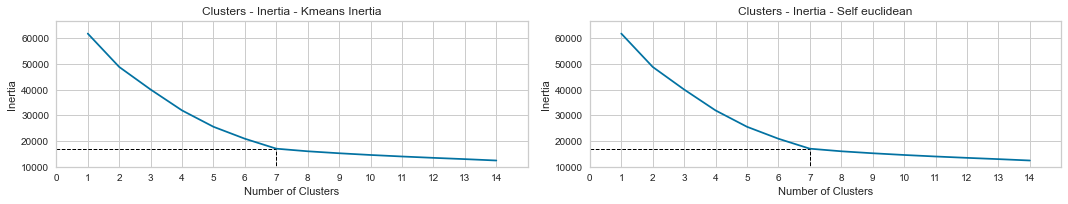

In [9]:
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
x = K

ax1.title.set_text('Clusters - Inertia - Kmeans Inertia')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_xlim([1, 15])
ax1.set_ylim([10000, inertias_kmeans[0]+5000])
ax1.set_xticks(np.arange(0, max(K)+1, step=1))
ax1.plot([7,7], [0.05,inertias_kmeans[6]], color = 'black', linewidth= 1, linestyle='dashed')
ax1.plot([0,7], [inertias_kmeans[6],inertias_kmeans[6]], color = 'black', linewidth= 1, linestyle='dashed')
ax1.plot(x, inertias_kmeans)

ax2.title.set_text('Clusters - Inertia - Self euclidean')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Inertia')
ax2.set_xlim([1, 15])
ax2.set_ylim([10000, own_inertias[0]+5000])
ax2.set_xticks(np.arange(0, max(K)+1, step=1))
ax2.plot([7,7], [0.05,own_inertias[6]], color = 'black', linewidth= 1, linestyle='dashed')
ax2.plot([0,7], [own_inertias[6],own_inertias[6]], color = 'black', linewidth= 1, linestyle='dashed')

ax2.plot(x, own_inertias)

f.tight_layout()

plt.show()


## Normalized Deviation (function to optimize)

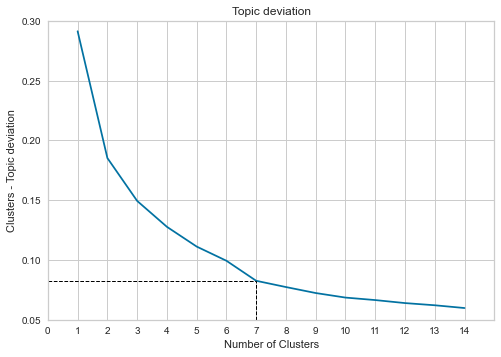

In [10]:
plt.plot(K,topic_deviation_kmeans)
plt.xticks(np.arange(0, max(K)+1, step=1))
plt.xlabel('Number of Clusters')
plt.ylabel('Topic deviation score')
plt.title('Topic deviation')
plt.ylim([0.05, 0.30])
plt.xlim([0, 15])
plt.plot([7,7], [0.05,topic_deviation_kmeans[6]], color = 'black', linewidth= 1, linestyle='dashed')
plt.plot([0,7], [topic_deviation_kmeans[6],topic_deviation_kmeans[6]], color = 'black', linewidth= 1, linestyle='dashed')
plt.show()

In [11]:
df_deviation = pd.DataFrame(columns = ['Number of clusters' , 'Topic deviation'])
df_deviation['Number of clusters'] = range(1,8)
df_deviation['Topic deviation'] = topic_deviation_kmeans[:7]
df_deviation

,Number of clusters,Topic deviation
0,1,0.291264
1,2,0.185241
2,3,0.149408
3,4,0.127748
4,5,0.111234
5,6,0.099365
6,7,0.082621


In [12]:
print("Real Inertias {}".format(inertias_kmeans[6]))
print("Calculated Inertias {}".format(own_inertias[6]))
print(topic_deviation_kmeans[6])

Real Inertias 17051.686448164186
Calculated Inertias 17051.686448164324
0.08262091374801658


### Yellowbrick

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

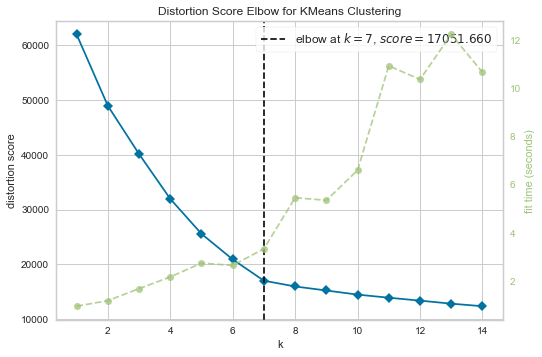

In [2]:
# Import ElbowVisualizer
matrix_np = joblib.load("matrix_np.pkl")
model = KMeans()
# k is range of number of clusters.
visualizer3 = KElbowVisualizer(KMeans(random_state=0), k=(1,15))
visualizer3.fit(matrix_np) # Fit the data to the visualizer
visualizer3.show(outpath='elbowplot.png') 

In [5]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(matrix_np) 
topic_deviation, inertia, euclidean_inertia = deviation(num_clusters=7, kmeans_labels= kmeans.labels_, cluster_vectors= kmeans.cluster_centers_, X= matrix_np)
df = pd.DataFrame(data = euclidean_inertia)
df

Cluster number: 7


,0
0,2716.056008
1,1970.720102
2,2917.532124
3,2019.106231
4,2326.805052
5,2550.665702
6,2550.801229


## Silhoutte

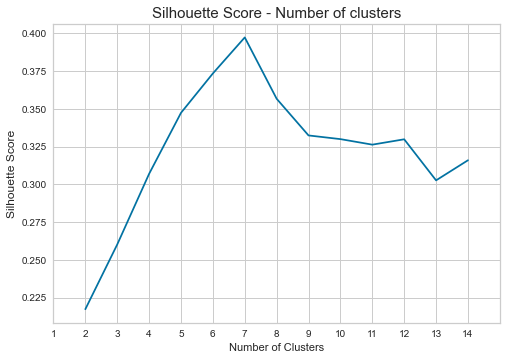

In [11]:
plt.plot(range(2,15), silhouette_coefficients_kmeans)
plt.xticks(np.arange(1, 15, step=1))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score', fontsize = 12)
plt.title('Silhouette Score - Number of clusters', fontsize = 15)
#plt.ylim([0.05, 0.30])
plt.xlim([1, 15])
#plt.plot([7,7], [0.05,topic_deviation_kmeans[6]], color = 'black', linewidth= 1, linestyle='dashed')
#plt.plot([0,7], [topic_deviation_kmeans[6],topic_deviation_kmeans[6]], color = 'black', linewidth= 1, linestyle='dashed')
plt.show()

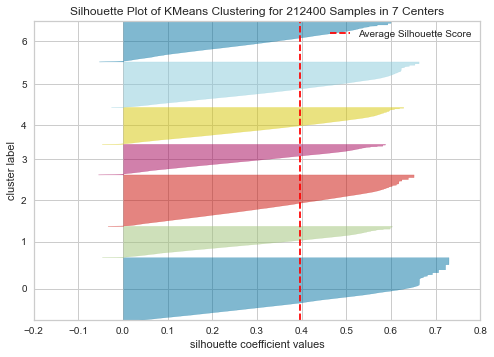

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 212400 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
model = KMeans(7, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(matrix_np)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Calinski-Harabasz Index

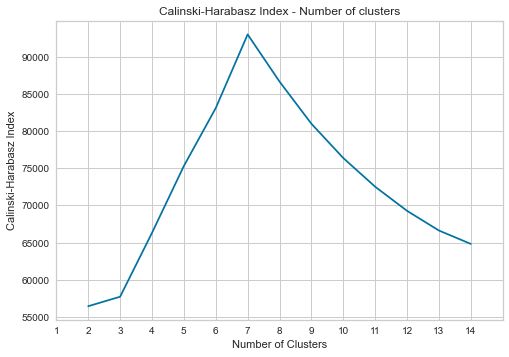

In [15]:
plt.plot(range(2,15),calinski_index_kmeans)
plt.xticks(np.arange(1, 15, step=1))
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index - Number of clusters')
plt.xlim([1, 15])
plt.show()

## Davies-Bouldin Index

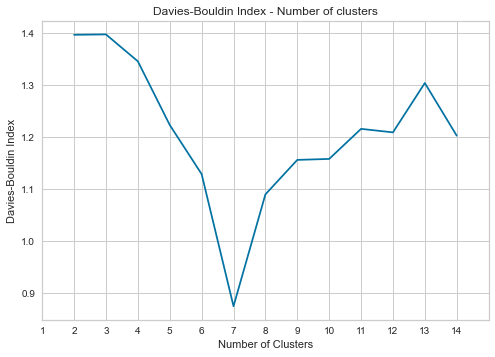

In [16]:
plt.plot(range(2,15),davies_bouldin_kmeans)
plt.xticks(np.arange(0, 15, step=1))
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index - Number of clusters')
plt.xlim([1, 15])
plt.show()

## Plot for k=7

### PCA

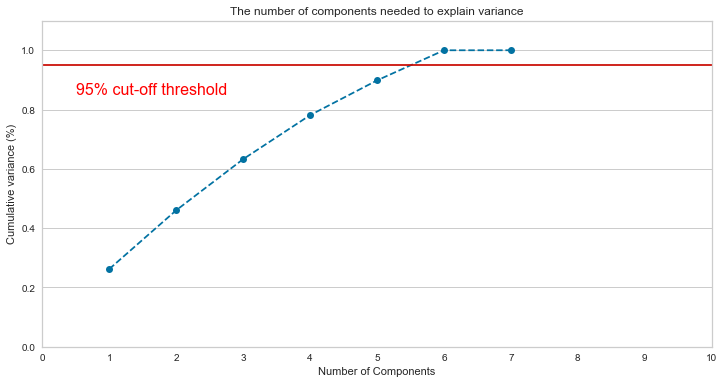

In [18]:
pca = PCA().fit(matrix_np)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 8, step=1)
y = np.cumsum(pca.explained_variance_ratio_)


plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### 2D plots

In [19]:
df_target = pd.DataFrame(data=kmeans_labels[6], columns=["target"])

In [20]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(matrix_np)

#Dataframe
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
# Concatenate with labels
finalDf = pd.concat([principalDf, df_target[['target']]], axis = 1)
finalDf

,principal component 1,principal component 2,target
0,-0.187972,0.056625,6
1,-0.201377,-0.005939,6
2,-0.184423,0.061725,6
3,0.233124,-0.139407,0
4,0.571210,-0.043247,0
...,...,...,...
212395,0.334477,-0.020574,0
212396,0.402302,-0.031209,0
212397,-0.220235,-0.162824,1
212398,-0.174785,0.290711,5


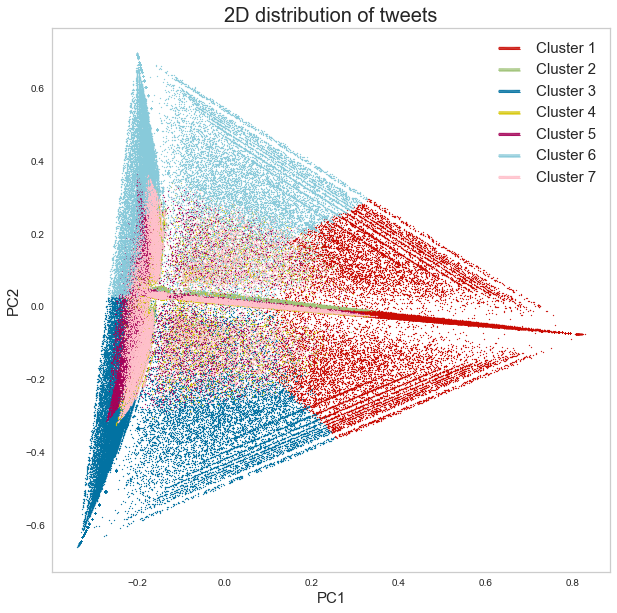

In [32]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2D distribution of tweets', fontsize = 20)
targets = ['0', '1', '2', '3', '4', '5', '6']
target_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7']

plt.scatter(finalDf.loc[finalDf['target'] == 0, 'principal component 1'].values, finalDf.loc[finalDf['target'] == 0, 'principal component 2'].values, color='r', s =1)
plt.scatter(finalDf.loc[finalDf['target'] == 1, 'principal component 1'].values, finalDf.loc[finalDf['target'] == 1, 'principal component 2'].values, color='g', s=1)
plt.scatter(finalDf.loc[finalDf['target'] == 2, 'principal component 1'].values, finalDf.loc[finalDf['target'] == 2, 'principal component 2'].values, color='b', s=1)
plt.scatter(finalDf.loc[finalDf['target'] == 3, 'principal component 1'].values, finalDf.loc[finalDf['target'] == 3, 'principal component 2'].values, color='y', s=1)
plt.scatter(finalDf.loc[finalDf['target'] == 4, 'principal component 1'].values, finalDf.loc[finalDf['target'] == 4, 'principal component 2'].values, color='m', s=1)
plt.scatter(finalDf.loc[finalDf['target'] == 5, 'principal component 1'].values, finalDf.loc[finalDf['target'] == 5, 'principal component 2'].values, color='c', s=1)
plt.scatter(finalDf.loc[finalDf['target'] == 6, 'principal component 1'].values, finalDf.loc[finalDf['target'] == 6, 'principal component 2'].values, color='pink', s=1)
ax.legend(target_labels, scatterpoints=60,  prop={"size":15})

ax.grid()

### Intercluster distance

C:\Users\alejandro\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


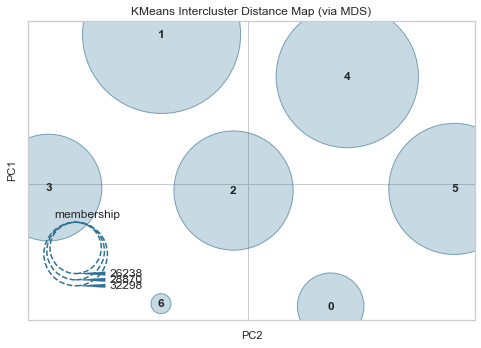

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [24]:
model = KMeans(7)
visualizer = InterclusterDistance(model, random_state=0)
visualizer.fit(matrix_np)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# MiniBatch K-Means

In [26]:
inertias_minibatch = []
own_inertias_minibatch = []
topic_deviation_minibatch = []
minibatch_labels = []
silhouette_coefficients_minibatch = []
calinski_index_minibatch = []
davies_bouldin_minibatch = []

start = time()

K = range(1,15)
for k in K:
    mb = MiniBatchKMeans(n_clusters=k, random_state=0).fit(matrix_np) 
    inertias_minibatch.append(mb.inertia_)
    minibatch_labels.append(mb.labels_)
    
    if(k>1):
        silhouette_coefficients_minibatch.append(silhouette_score(matrix_np, mb.labels_))
        calinski_index_minibatch.append(metrics.calinski_harabasz_score(matrix_np, mb.labels_))
        davies_bouldin_minibatch.append(davies_bouldin_score(matrix_np, mb.labels_))
    
    
print('Time used for calculating MiniBatch K-Means: {:.2f}s'.format(time()-start)) 

Time used for calculating MiniBatch K-Means: 6112.50s


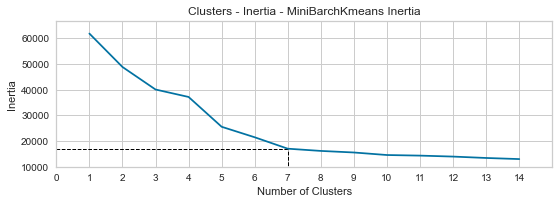

In [27]:
f = plt.figure(figsize=(15,3))
ax1 = f.add_subplot(121)

x = K

ax1.title.set_text('Clusters - Inertia - MiniBarchKmeans Inertia')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_xlim([1, 15])
ax1.set_ylim([10000, inertias_minibatch[0]+5000])
ax1.set_xticks(np.arange(0, max(K)+1, step=1))
ax1.plot([7,7], [0.05,inertias_minibatch[6]], color = 'black', linewidth= 1, linestyle='dashed')
ax1.plot([0,7], [inertias_minibatch[6],inertias_minibatch[6]], color = 'black', linewidth= 1, linestyle='dashed')
ax1.plot(x, inertias_minibatch)


f.tight_layout()

plt.show()


## Silhoutte

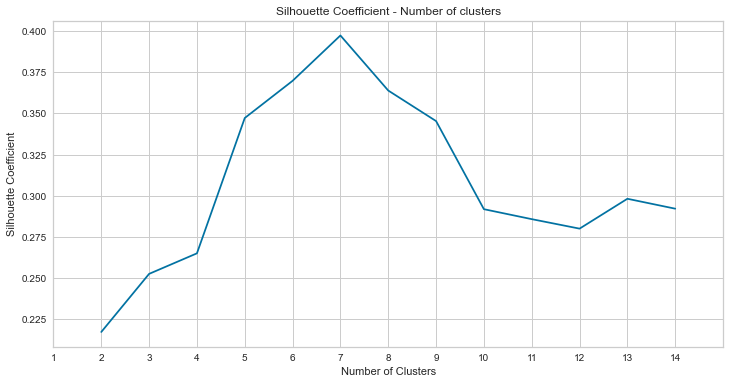

In [28]:
plt.plot(range(2,15), silhouette_coefficients_minibatch)
plt.xticks(np.arange(1, 15, step=1))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient - Number of clusters')
#plt.ylim([0.05, 0.30])
plt.xlim([1, 15])
#plt.plot([7,7], [0.05,topic_deviation_kmeans[6]], color = 'black', linewidth= 1, linestyle='dashed')
#plt.plot([0,7], [topic_deviation_kmeans[6],topic_deviation_kmeans[6]], color = 'black', linewidth= 1, linestyle='dashed')
plt.show()

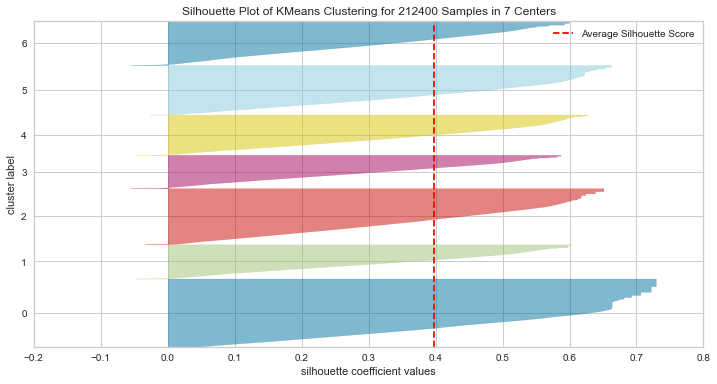

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 212400 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [29]:
model = KMeans(7, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(matrix_np)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Calinski-Harabasz Index

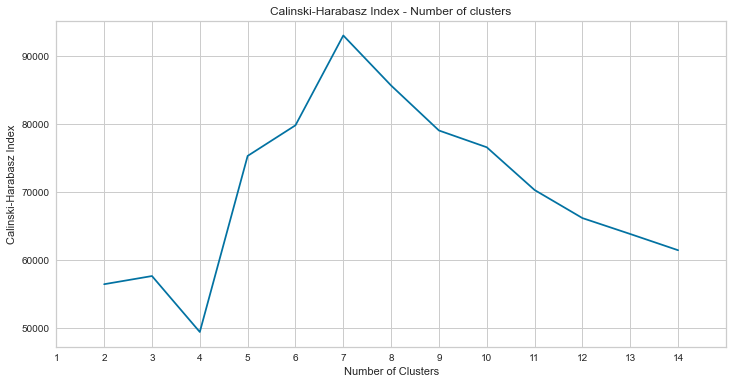

In [31]:
plt.plot(range(2,15),calinski_index_minibatch)
plt.xticks(np.arange(1, 15, step=1))
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index - Number of clusters')
plt.xlim([1, 15])
plt.show()

# Birch Clustering

In [10]:
silhouette_coefficients_birch = []
calinski_index_birch = []
davies_bouldin_birch = []

start = time()


brc = Birch(n_clusters=7, branching_factor = 50, threshold = 0.5).fit(matrix_np)    

#brc = Birch(n_clusters=None, branching_factor = 50, threshold = 0.5).fit(matrix_np)    

calinski_index_birch.append(metrics.calinski_harabasz_score(matrix_np, brc.labels_))
davies_bouldin_birch.append(davies_bouldin_score(matrix_np, brc.labels_))
silhouette_coefficients_birch.append(silhouette_score(matrix_np, brc.labels_))
        
        
print('Time used for calculating : {:.2f}s'.format(time()-start)) 

Time used for calculating : 581.47s


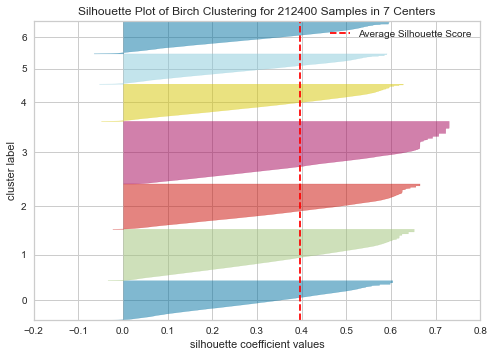

<AxesSubplot:title={'center':'Silhouette Plot of Birch Clustering for 212400 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [4]:
matrix_np = joblib.load("matrix_np.pkl")
model = Birch(n_clusters = 7)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(matrix_np)        # Fit the data to the visualizer
visualizer.show()     

## Birch Metrics for k=7

In [12]:
print("Birch silhouette coefficient: {}".format(silhouette_coefficients_birch))
print("Birch Calinski-Harabasz Index: {}".format(calinski_index_birch))
print("Birch Davies-Bouldin Index: {}".format(davies_bouldin_birch))

Birch silhouette coefficient: [0.3972870722298065]
Birch Calinski-Harabasz Index: [93001.14016147064]
Birch Davies-Bouldin Index: [0.8704857357143754]
